# Banana Ripeness Classifier with fastai 🍌

## 1. Problem Definition

### Use Case & Motivation

Bananas go through several ripeness stages that affect taste, texture, and how they should be used (eaten fresh, used for baking, etc.). Automatically classifying ripeness from an image can help:

- Reduce food waste (identify still-good vs truly rotten bananas)
- Automate quality control in supermarkets & warehouses
- Build consumer apps that advise when to eat or use bananas

In this project, we build an **image classifier** that predicts **banana ripeness stage** from a photo using the fastai library.

### Classes

The dataset we use contains **three classes**:

- `unripe` – green or mostly green bananas  
- `ripe` – yellow bananas, ready to eat  
- `rotten` – very brown/black bananas that are no longer good for fresh consumption  

These three categories correspond to the folders in the public dataset repository.

### Expected Challenges

- Different lighting conditions and camera quality  
- Background clutter (kitchens, tables, stores, etc.)  
- Bananas at mixed ripeness levels in a single image  
- Subtle differences between ripe and slightly rotten bananas

---

## 2. Dataset Overview

We use the open dataset:

> **Jorgusheska, I.** *Banana Ripeness Level Recognition* – GitHub repository containing 300 images of bananas categorized into three ripeness levels: **unripe, ripe, rotten**, with 100 images per class.

GitHub repository: https://github.com/IvaJorgusheska/Banana_Ripeness_Level_Recognition

Original structure of the repo:

```text
Banana_Ripeness_Level_Recognition/
    unripe/   # 100 images
    ripe/     # 100 images
    rotten/   # 100 images




In [ ]:

### Code: Imports & Paths

from fastai.vision.all import *
import random, shutil, subprocess, os

# Base project path
path = Path('banana_ripeness')
path.mkdir(exist_ok=True)
path

Path('banana_ripeness')

In [ ]:
repo_url = "https://github.com/IvaJorgusheska/Banana_Ripeness_Level_Recognition.git"
repo_dir = Path("Banana_Ripeness_Level_Recognition")

if not repo_dir.exists():
    print("Cloning dataset repository...")
    subprocess.run(["git", "clone", repo_url], check=True)
else:
    print("Repository already exists, skipping clone.")

repo_dir


Cloning dataset repository...


Path('Banana_Ripeness_Level_Recognition')

## 3. Preparing the Dataset

The original repo already has one folder per class:

- `unripe/`
- `ripe/`
- `rotten/`

Steps:

1. **Check image counts** per class.
2. **Create a 20% held-out test set**:
   - Randomly select 20% of images from each class as test.
   - Put them in `banana_ripeness/test/<class>/`
   - Remaining 80% go to `banana_ripeness/train/<class>/`

This ensures the test set never influences model training or hyperparameters.



In [ ]:
classes = ['unripe', 'ripe', 'rotten']

for c in classes:
    class_folder = repo_dir/c
    files = list(class_folder.glob('*'))
    print(f"Class '{c}': {len(files)} files in original repo")


Class 'unripe': 101 files in original repo
Class 'ripe': 101 files in original repo
Class 'rotten': 101 files in original repo


In [ ]:
random.seed(42)  # reproducibility

test_pct = 0.2

train_path = path/'train'
test_path  = path/'test'

for c in classes:
    orig_folder = repo_dir/c
    files = list(get_image_files(orig_folder))
    n_test = max(1, int(len(files) * test_pct))

    print(f"Class '{c}': total {len(files)} images, moving {n_test} to test set.")

    test_files = random.sample(files, n_test)

    # Destination folders
    (test_path/c).mkdir(parents=True, exist_ok=True)
    (train_path/c).mkdir(parents=True, exist_ok=True)

    # Move test files
    for f in test_files:
        shutil.copy2(f, test_path/c/f.name)

    # Move train files (the remaining ones)
    remaining = [f for f in files if f not in test_files]
    for f in remaining:
        shutil.copy2(f, train_path/c/f.name)

print("Finished creating train/ and test/ splits (copy-based).")


Class 'unripe': total 100 images, moving 20 to test set.
Class 'ripe': total 100 images, moving 20 to test set.
Class 'rotten': total 100 images, moving 20 to test set.
Finished creating train/ and test/ splits (copy-based).


In [ ]:
for split in ['train', 'test']:
    print(f"\nSplit: {split}")
    for c in classes:
        count = len(list((path/split/c).glob('*')))
        print(f"  {c}: {count} images")



Split: train
  unripe: 80 images
  ripe: 80 images
  rotten: 80 images

Split: test
  unripe: 20 images
  ripe: 20 images
  rotten: 20 images


## 4. Building DataLoaders in fastai

Now we create fastai `DataLoaders` from `banana_ripeness/train`:

- Use `DataBlock` with:
  - `ImageBlock` (input)
  - `CategoryBlock` (label)
  - `get_items = get_image_files`
  - `get_y = parent_label` (folder name as label)
  - `RandomSplitter(valid_pct=0.2, seed=42)` to create a validation set **from train only**
- Apply basic transforms and resize images to 224×224.

The **test set** in `banana_ripeness/test` remains completely separate.


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=1.0)
)

dls = dblock.dataloaders(train_path, bs=32)
dls


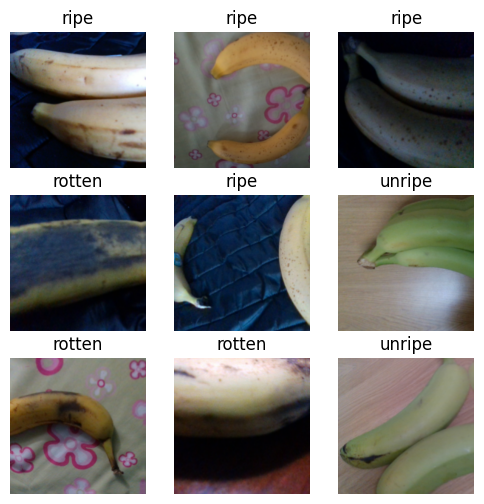

In [ ]:
dls.show_batch(max_n=9, figsize=(6,6))


## 5. Model Training (Transfer Learning)

We use fastai's `vision_learner` with a pre-trained **ResNet-18** backbone:

- Pretrained on ImageNet
- Fine-tuned on my banana ripeness dataset
- Metric: `accuracy`

Training steps:

1. Create learner with `vision_learner`.
2. Call `fine_tune` for a few epochs.
3. Inspect training loss curves.



In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
# The fine_tune method trains in two stages:
# 1. Trains the 'head' of the model (new layers) for 1 epoch, freezing the pre-trained backbone.
# 2. Unfreezes the entire model and trains all layers for the specified number of epochs (here, 5).
# This two-stage process is why you see two tables in the output, one for each stage.
learn.fine_tune(5)  # can increase epochs if training is fast enough

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.498071,0.442123,0.875000,00:54


epoch,train_loss,valid_loss,accuracy,time
0,0.347198,0.126591,0.958333,01:19
1,0.265539,0.036882,0.979167,01:08
2,0.204755,0.039686,0.979167,01:12
3,0.152687,0.037819,0.979167,01:10
4,0.119319,0.031159,0.979167,01:15


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

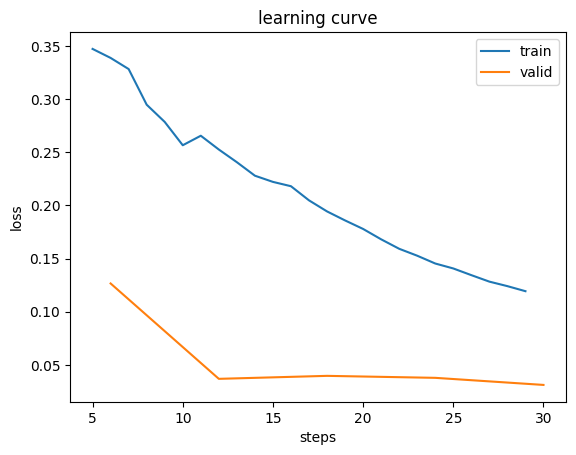

In [ ]:
learn.recorder.plot_loss()


## 6. Validation Set Evaluation

First, we evaluate the model on the **validation set** (held out from the training data):

- Confusion matrix to see common mistakes
- Top losses (images where the model was most wrong)

This helps diagnose whether certain classes are harder or more confusing.


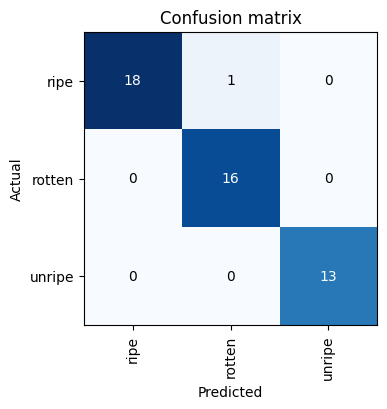

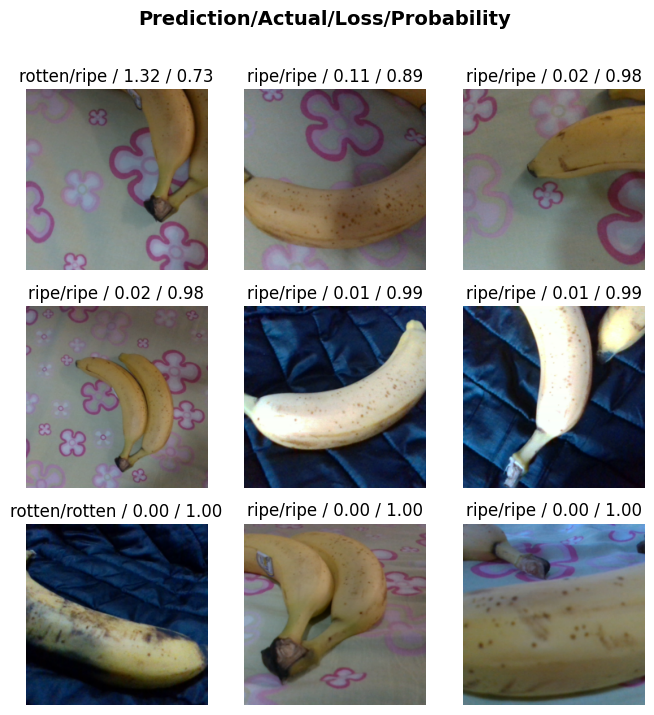

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(4,4))

# Top losses
interp.plot_top_losses(9, nrows=3, figsize=(8,8))


### Discussion of Validation Performance

Things to comment on:

- Based on the confusion matrix a ripe banana was predicted to be rotten, the image was dark and banana was cut in the picture which might have led to the confusion.
- We assume that lighting and image cutting can change the accuracy of a prediction.
- Its hard for us as humans to draw a strict line between diffrent classes. for example, a banana with brown marks looked slightly rotten to me but was marked as ripe.

---

## 7. Evaluation on the 20% Held-Out Test Set

Now we evaluate on the **test set** in `banana_ripeness/test/`, which has:

- 20% of the images from each class
- Never used during training or validation

Steps:

1. Build a test DataLoader.
2. Get predictions and compute test accuracy.
3. Visualize some predictions.


In [ ]:
test_files = get_image_files(test_path)
len(test_files), test_files[:5]


(60,
 (#5) [Path('banana_ripeness/test/rotten/rotten39_Color.png'),Path('banana_ripeness/test/rotten/rotten43_Color.png'),Path('banana_ripeness/test/rotten/rotten90_Color.png'),Path('banana_ripeness/test/rotten/rotten97_Color.png'),Path('banana_ripeness/test/rotten/rotten28_Color.png')])

In [ ]:
# Create a test DataLoader
test_dl = dls.test_dl(test_files)

# Get predictions
preds, _ = learn.get_preds(dl=test_dl)
pred_idxs = preds.argmax(dim=1)

# Ground-truth labels from folder names
vocab = dls.vocab
label2idx = {label: i for i, label in enumerate(vocab)}

true_labels = [parent_label(f) for f in test_files]
true_idxs = tensor([label2idx[l] for l in true_labels])

test_acc = (pred_idxs == true_idxs).float().mean().item()
print(f"Test set accuracy: {test_acc:.4f}")


Test set accuracy: 0.9833


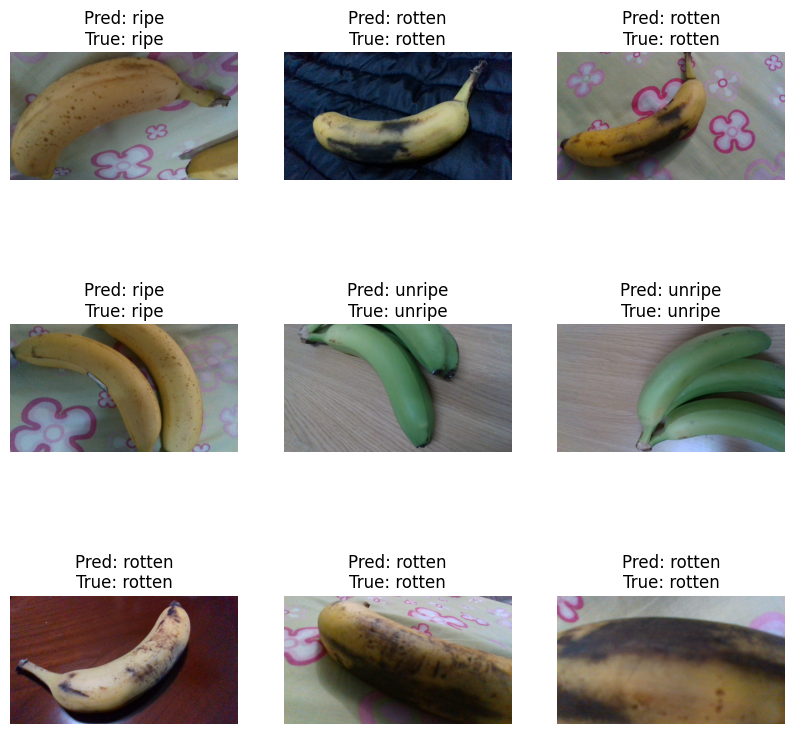

In [ ]:
import math

def show_test_predictions(n=9):
    sample_files = random.sample(list(test_files), min(n, len(test_files)))
    ims = [PILImage.create(f) for f in sample_files]
    preds, _ = learn.get_preds(dl=dls.test_dl(sample_files))
    pred_idxs = preds.argmax(dim=1)

    nrows = int(math.sqrt(len(sample_files)))
    ncols = math.ceil(len(sample_files) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
    axs = axs.flatten()

    for ax, img, f, pred_idx in zip(axs, ims, sample_files, pred_idxs):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Pred: {vocab[pred_idx]}\nTrue: {parent_label(f)}")

    # Hide any unused axes
    for ax in axs[len(sample_files):]:
        ax.axis('off')

show_test_predictions(9)


## 8. Discussion of Test Results & Model Weaknesses

Here we summarize the final model performance on the **unseen test set**:

- **Test accuracy:** 0.9833
- the test prediction is very accurate, in the shown examples there were no errors.